In [1]:
%%bash
export OMP_NUM_THREADS=56
export MKL_NUM_THREADS=56

## Template provided

In [2]:
import numpy as np
import matplotlib.pyplot as plt


points = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                   [0, 0, 1, 1, 0, 0, 1, 1],
                   [0, 1, 0, 1, 0, 1, 0, 1],
                   [1, 1, 1, 1, 1, 1, 1, 1]])


def plotcube(pt, P):
    """plot a cube described by pt. 
       T is the transition matrix that maps objects from a 3D space to a 2D screen.
       The camera is at [1/2, 1/2, sqrt(2)/2]"""

    def drawAxis():
        """ draw the axes of the 3D space"""
        X = np.dot(P, [[0, 1.5], [0, 0], [0, 0], [1, 1]])
        Y = np.dot(P, [[0, 0], [0, 1.5], [0, 0], [1, 1]])
        Z = np.dot(P, [[0, 0], [0, 0], [0, 1.5], [1, 1]])

        np.divide(X[0:2, 0:2], X[2, 0:2], X[0:2, 0:2])
        np.divide(Y[0:2, 0:2], Y[2, 0:2], Y[0:2, 0:2])
        np.divide(Z[0:2, 0:2], Z[2, 0:2], Z[0:2, 0:2])

        plt.plot(X[0, 0:2], 100-X[1, 0:2], 'b:')
        plt.plot(Y[0, :], 100-Y[1, :], 'b:')
        plt.plot(Z[0, :], 100-Z[1, :], 'b:')
        plt.text(X[0, 1], 100-X[1, 1], r'x', fontsize=20)
        plt.text(Y[0, 1], 100-Y[1, 1], r'y', fontsize=20)
        plt.text(Z[0, 1]-0.1, 100-Z[1, 1], r'z', fontsize=20)

    def mapRectangle(p1, p2, p3, p4):
        """return two 1D arrays: X list and Y list from
           points[:, p1], points[:,p2], points[:, p3], points[:, p4]"""
        A = np.dot(P, points[:, [p1, p2, p3, p4, p1]])
        np.divide(A[0:2, :], A[2, :], A[0:2, :])
        return A[0, :], 100-A[1, :]

    drawAxis()

    # plot face 1
    X1, Y1 = mapRectangle(0, 1, 3, 2)
    plt.plot(X1, Y1)

    # plot face 2
    X2, Y2 = mapRectangle(4, 6, 7, 5)
    plt.plot(X2, Y2)

    # plot face 3
    X3, Y3 = mapRectangle(0, 2, 6, 4)
    plt.plot(X3, Y3)

    # plot face 4
    X4, Y4 = mapRectangle(1, 5, 7, 3)
    plt.plot(X4, Y4)

    # plot face 5
    X5, Y5 = mapRectangle(0, 4, 5, 1)
    plt.plot(X5, Y5)

    # plot face 6
    X6, Y6 = mapRectangle(2, 3, 7, 6)
    plt.plot(X6, Y6)

    plt.axis('equal')

    plt.show()

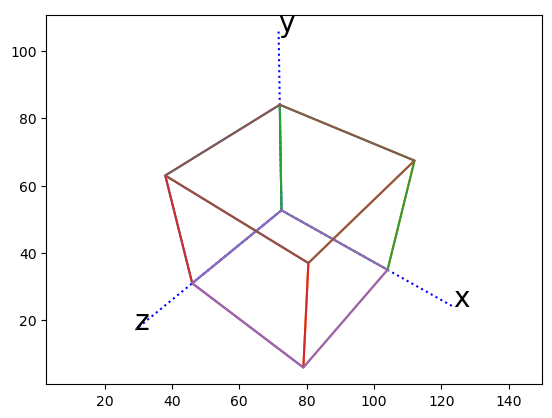

In [3]:
img = np.array([[46, 72, 38, 104, 79, 112, 83],
                [69, 16, 37,  65, 94,  33, 65]])

A = np.zeros([14, 11])
b = np.zeros([14, 1])
for i in range(7):
    j = 2*i
    A[j, 0:4] = points[:, i+1].T
    A[j, 8:11] = -1.0 * img[0, i] * points[0:3, i+1].T
    A[j+1, 4:8] = points[:, i+1].T
    A[j+1, 8:11] = -1.0 * img[1, i] * points[0:3, i+1].T
    b[j] = img[0, i]
    b[j+1] = img[1, i]
    
A1 = A[0:11, :]
b1 = b[0:11]
x = np.append(np.linalg.solve(A1, b1), 1)
P = np.reshape(x, (3, 4))

plotcube(points, P)

# Different Selections of Equations

It's obvious that there are $\binom{14}{11}=364$ combinations. As a consequence, it's not hard to enumerate all selections and measure, compare their performances.

Each one was iterated $10000$ times in loop and repeat $5$ times. We should be cautious that some combinations are singular which means that it couldn't lead to a solution.

In [4]:
from itertools import combinations as C


mn = None
mx = None
for c in C(range(14), 11):
    s = list(c)
    Ap = A[s, :]
    bp = b[s]
    try:
        t = %timeit -o -q -n10000 -r7 x = np.append(np.linalg.solve(Ap, bp), 1)
        if not mn or t.average < mn[1].average:
            mn = (s, t)
        if not mx or t.average > mx.average:
            mx = t
    except:
        continue
    # P = np.reshape(x, (3, 4))

print(mn[0])
print(mn[1])
print(mx)

[0, 1, 2, 4, 5, 7, 8, 9, 11, 12, 13]
9.05 µs ± 33.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
9.84 µs ± 756 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The $\min$imum was $9.05\mu s$ whereas the $\max$imum being $9.84\mu s$. Note that even though the amount of iterations had been increased again and again, the result still varied and diverged. That is to say, we failed to obtain an optimal combination that is ensured to yield the best result all times. Still, we could see that it seems that if we select row $8$, $13$ then the result have a tendency to be a bit better.

```
[0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13] // 9.23
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] // 9.23
[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13] // 9.12
[1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13] // 9.18
[0, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13] // 9.19
[0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13] // 9.13
[0, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13] // 9.18
[0, 1, 2, 3, 4, 5, 7, 8, 10, 12, 13] // 9.08
[0, 1, 2, 4, 5, 7, 8, 9, 11, 12, 13] // 9.05
```

# Using _linear least square_

`numpy.linalg.lstsq()` was also iterated $10000$ times in loop and repeat $5$ times.

In [5]:
%timeit -n10000 -r7 x = np.append(np.linalg.lstsq(A, b)[0], 1)

<magic-timeit>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


38.9 µs ± 5.47 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


We could find that the CPU time consumed by  _linear least square_ was about $4$ times the slowest one in different selections of equations. So why's the reason? I sought the documentation of `numpy.linalg.lstsq()` and found that first the function returns more additional informations  such as _residual sum of squares (or the difference between the measured and projected point)_, _rank_ and _singular values_ of $A$. Moreover, it also said that::
> If there are multiple minimizing solutions, the one with the smallest $2$-norm $||x||$ is returned.

For the purpose of doing so, the matrix needs be examined and sometimes solved by means of **Pseudo Inverse**, while there are faster approach such as **QR decomposition**.

Nevertheless, the returned matrix of `numpy.linalg.lstsq()` tended to be more stable.

# Take a photo of a rectangular object

Below is a shoe box I chose of size $33$ by $18.5$ by $12$ cm that is suitable for this task. The 2D coordinates of its vertices have been labeled on the figure by hands.

![](A2_110062219.JPG)

Despite the fact that the box isn't cubic, we could still project the box to the unit cube in the first octant since we could consider the project matrix also performs the _scaling_ linear transformation. I constructed the table of the corresponding of 3D points between 2D also by hands.

|    3D     |      2D      |
|:---------:|:------------:|
| (0, 0, 1) | (32.5, 66.5) |
| (0, 1, 0) |  (55, 30.5)  |
| (0, 1, 1) |  (27, 47.5)  |
| (1, 0, 0) | (109.5, 72)  |
| (1, 0, 1) | (92, 102.5)  |
| (1, 1, 0) | (115.5, 52)  |
| (1, 1, 1) |  (94.5, 83)  |

## Compute the projection matrix

In [6]:
img = np.array([[32.5, 55, 27, 109.5, 92, 115.5, 94.5],
                [66.5, 30.5, 47.5, 72, 102.5, 52, 83]])

A = np.zeros([14, 11])
b = np.zeros([14, 1])
for i in range(7):
    j = 2 * i
    A[j, 0 : 4] = points[:, i + 1].T
    A[j, 8 : 11] = -1.0 * img[0, i] * points[0 : 3, i + 1].T
    A[j + 1, 4 : 8] = points[:, i + 1].T
    A[j + 1, 8 : 11] = -1.0 * img[1, i] * points[0 : 3, i + 1].T
    b[j] = img[0, i]
    b[j + 1] = img[1, i]

# s = np.random.choice(range(14), 11, replace=False)
s = np.concatenate(([3, 8, 13], np.random.choice([0, 2, 4, 5, 6, 7, 9, 10, 11, 12], 8, replace=False)))
Ap = A[s, :]
bp = b[s]
x = np.append(np.linalg.solve(Ap, bp), 1)
P = np.reshape(x, (3, 4))

print(P)

[[ 27.32705956 -12.59046806 -27.92830833  59.3337975 ]
 [  7.42640673 -24.90881322   7.17919923  50.8301141 ]
 [ -0.20857665  -0.15012128  -0.15302608   1.        ]]


## Draw the 3D Model

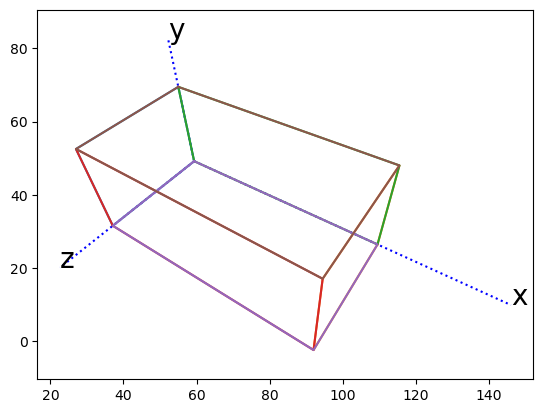

In [7]:
plotcube(points, P)

# Automatically Select the Corresponding Points

I found this [document](https://docs.opencv.org/3.4/d4/d8c/tutorial_py_shi_tomasi.html) being of help toward this task online, looked into the computer vision library **OpenCV** and made use of `cv2.goodFeaturesToTrack()` to apply _Shi-Tomasi_ algorithm to find desired corners in the image.

First I preset the threshold and minimum distance and find the 7 most-likely corners, or vertices. Then, I assume that the rightmost point on 2D must be $(0,0,1)$ in 3D, says $pa$ , the topmost one must be $(0,1,0)$, says $pb$ and the bottomost and the right most must be $(1,0,0)$ and $(1,0,1)$, says $pc$ and $pd$ resp. For the remaining points, if its x-distance to $pa$ is less than the one to the minimum of $pa$, $pc$, then I assume it must be $(0,0,0)$ in 3D. Else if its x-distance to $pd$ is less than the one to the maximum of $pa$, $pc$, then I assume it must be $(0,0,0)$ in 3D. Else if its x-distance to $pa$ is less than the one to the minimum of $pa$, $pc$, then I assume it must be $(0,1,1)$ in 3D. Otherwise, I assume the point to be $(1,1,1)$ in 3D.

Nevertheless, I tried several photoes in real-life including the one for the third question yet their results were all quite awful. As a consequence, I turned to some simple 3D model images generated by some tools and found that my codes worked indeed. Furthermore, I tested a screenshot taken in the game Minecraft.

I believe that it may be the inevitable vast amount of noises plus the complex inhered informations for the real-life photoes such that my codes couldn't give ideal outcome. It might require some additional effort such as proper preprocessing, Gaussian blurring, but it's supposed to be beyond this course, Linear Algebra.

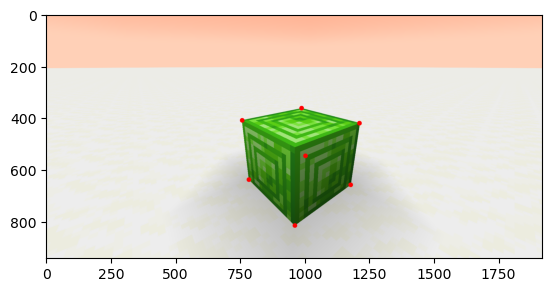

In [8]:
import cv2


img = cv2.imread("A2_110062219.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

corners = np.int0(cv2.goodFeaturesToTrack(gray, 7, 0.01, 174))

pts = []
pa = pb = pc = pd = None

for i in corners:
    x, y = i.ravel()
    cv2.circle(img, (x, y), 9, 255, -1)
    pts.append((x, y))
    if not pa or pa[1] > y:
        pa = (x, y)
    if not pb or pb[0] > x:
        pb = (x, y)
    if not pc or pc[1] < y:
        pc = (x, y)
    if not pd or pd[0] < x:
        pd = (x, y)

plt.imshow(img)

[[ 785  989  759 1179  963 1213 1004]
 [ 639  363  410  659  816  421  547]]
[[-1.31375769e+02 -2.79785071e+02 -3.27511517e+02  1.01977817e+03]
 [-6.03702829e+01 -2.85336109e+02 -4.87890130e+01  5.56941263e+02]
 [-2.46478027e-01 -2.51776437e-01 -2.04769562e-01  1.00000000e+00]]


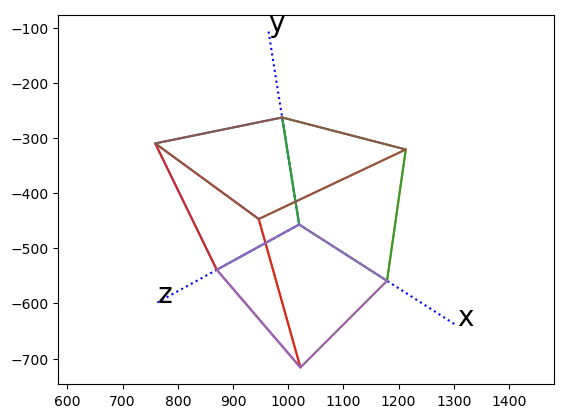

In [9]:
img = np.array([[-1, pa[0], pb[0], -1, pc[0], pd[0], -1],
                [-1, pa[1], pb[1], -1, pc[1], pd[1], -1]])
for x, y in pts:
    if abs(pb[0] - x) < abs(x - min(pa[0], pc[0])):
        img[0][0], img[1][0] = x, y
    elif abs(pd[0] - x) < abs(x - max(pa[0], pc[0])):
        img[0][3], img[1][3] = x, y
    elif (x, y) not in (pa, pb, pc, pd):
        img[0][6], img[1][6] = x, y
print(img)
        
A = np.zeros([14, 11])
b = np.zeros([14, 1])
for i in range(7):
    j = 2 * i
    A[j, 0 : 4] = points[:, i + 1].T
    A[j, 8 : 11] = -1.0 * img[0, i] * points[0 : 3, i + 1].T
    A[j + 1, 4 : 8] = points[:, i + 1].T
    A[j + 1, 8 : 11] = -1.0 * img[1, i] * points[0 : 3, i + 1].T
    b[j] = img[0, i]
    b[j + 1] = img[1, i]

s = np.random.choice(range(14), 11, replace=False)
# s = np.concatenate(([3, 8, 13], np.random.choice([0, 2, 4, 5, 6, 7, 9, 10, 11, 12], 8, replace=False)))
Ap = A[s, :]
bp = b[s]
x = np.append(np.linalg.solve(Ap, bp), 1)
P = np.reshape(x, (3, 4))

print(P)

plotcube(points, P)

Though we could see that the 3D point $(1,1,1)$ wasn't marked precisely, yet in my opinion, it looked fine enough. And I found that the results might differ, despite the fact that I also tried to fix the selection slice of equations (rows of $A$, $b$). Sometimes the result went quite weird. In these cases, we might need rerun cell 28, 29 again.

```
[[ 785  989  759 1179  963 1213 1004]
 [ 639  363  410  659  816  421  547]]
[[-2.96403573e+01 -1.05510592e+02 -3.14722514e+02  9.85997784e+02]
 [-1.17468155e+00 -2.39248041e+02  9.13632218e+00  5.35729003e+02]
 [-1.88840181e-01 -1.09719725e-01 -1.44872267e-01  1.00000000e+00]]

[[ 785  989  759 1179  963 1213 1004]
 [ 639  363  410  659  816  421  547]]
[[-1.13253767e+02 -2.68524019e+02 -3.08791585e+02  9.70029784e+02]
 [-7.39205994e+01 -3.12079896e+02 -3.13024384e+01  5.69558756e+02]
 [-2.73302785e-01 -2.90691846e-01 -1.57658345e-01  1.00000000e+00]]
 
[[ 785  989  759 1179  963 1213 1004]
 [ 639  363  410  659  816  421  547]]
[[-1.08042704e+02  2.40972973e+01 -2.78738955e+02  9.64414520e+02]
 [-5.72334348e+01 -1.73080154e+02  2.22476726e+01  5.35900972e+02]
 [-2.73645618e-01 -4.93612233e-04 -1.26527942e-01  1.00000000e+00]]
 
[[ 785  989  759 1179  963 1213 1004]
 [ 639  363  410  659  816  421  547]]
[[-1.31375769e+02 -2.79785071e+02 -3.27511517e+02  1.01977817e+03]
 [-6.03702829e+01 -2.85336109e+02 -4.87890130e+01  5.56941263e+02]
 [-2.46478027e-01 -2.51776437e-01 -2.04769562e-01  1.00000000e+00]]
 ```

# Acknowledgements

I thank to National Center for High-performance Computin _(NCHC)_ for providing computational and storage resources.